In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-5371946b-bc7a-8404-76f2-94eebc42c1b7)


In [3]:
!tree -d ../images

../images
├── Collection1
│   └── BAYC
└── Collection2
    └── EAPES

4 directories


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
import random
# Set random seed for reproducibility
# manualSeed = 42
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  6541


In [7]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            self._block(channels_noise, features_g * 16, 4, 1, 0),  # img: 4x4
            self._block(features_g * 16, features_g * 8, 4, 2, 1),  # img: 8x8
            self._block(features_g * 8, features_g * 4, 4, 2, 1),   # img: 16x16
            self._block(features_g * 4, features_g * 2, 4, 2, 1),   # img: 32x32
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            # Output: N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            # input: N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _block(in_channels, out_channels, kernel_size, stride, padding)
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            # After all _block img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [79]:
DATAROOT = '../images'          # Root directory for dataset
NUM_GPU = 1                     # Number of GPUs available. Use 0 for CPU mode.
LEARNING_RATE = 0.0002          # Learning rate for optimizers. could also use two lrs, one for gen and one for disc
BATCH_SIZE = 32                 # Batch size during training
IMAGE_SIZE = 64                 # Spatial size of training images. All images will be resized to this size using a transformer.              
CHANNELS_IMG = 3                # Number of channels in the training images. For color images this is 3
NOISE_DIM = 100                 # Size of z latent vector (i.e. size of generator input)
NUM_EPOCHS = 5                  # Number of training epochs
FEATURES_DISC = 64              # Size of feature maps in discriminator
FEATURES_GEN = 64               # Size of feature maps in generator
BETA = 0.5                      # Beta1 hyperparam for Adam optimizers

device = torch.device("cuda" if (torch.cuda.is_available() and NUM_GPU > 0) else "cpu")

transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

dataset = datasets.ImageFolder(root=DATAROOT, transform=transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
gen.apply(weights_init)
disc.apply(weights_init)

# Initialize BCELoss function
criterion = nn.BCELoss()
# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1, device=device)
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
# Setup Adam optimizers for both G and D
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA, 0.999))


    def weights_init(self, model):
        # Initializes weights according to the DCGAN paper
        for m in model.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
                nn.init.normal_(m.weight.data, 0.0, 0.02)

    def train(self):
        writer_real = SummaryWriter(f"logs/real")
        writer_fake = SummaryWriter(f"logs/fake")

        # Training Loop

        # Lists to keep track of progress
        img_list = []
        G_losses = []
        D_losses = []
        iters = 0

        # For each epoch
        for epoch in range(NUM_EPOCHS):
            # For each batch in the dataloader
            if epoch % 5 == 0:
                time.sleep(1)
                print("Epochs done: {}".format(epoch))
                time.sleep(1)
            for i, data in enumerate(tqdm(dataloader)):

                ############################
                # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
                ###########################
                ## Train with all-real batch
                disc.zero_grad()
                # Format batch
                real_cpu = data[0].to(device)
                b_size = real_cpu.size(0)
                label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
                # Forward pass real batch through D
                output = disc(real_cpu).view(-1)
                # Calculate loss on all-real batch
                errD_real = criterion(output, label)
                # Calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()

                ## Train with all-fake batch
                # Generate batch of latent vectors
                noise = torch.randn(b_size, NOISE_DIM, 1, 1, device=device)
                # Generate fake image batch with G
                fake = gen(noise)
                label.fill_(fake_label)
                # Classify all fake batch with D
                output = disc(fake.detach()).view(-1)
                # Calculate D's loss on the all-fake batch
                errD_fake = criterion(output, label)
                # Calculate the gradients for this batch, accumulated (summed) with previous gradients
                errD_fake.backward()
                D_G_z1 = output.mean().item()
                # Compute error of D as sum over the fake and the real batches
                errD = errD_real + errD_fake
                # Update D
                opt_disc.step()

                ############################
                # (2) Update G network: maximize log(D(G(z)))
                ###########################
                gen.zero_grad()
                label.fill_(real_label)  # fake labels are real for generator cost
                # Since we just updated D, perform another forward pass of all-fake batch through D
                output = disc(fake).view(-1)
                # Calculate G's loss based on this output
                errG = criterion(output, label)
                # Calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                # Update G
                opt_gen.step()

                # Save Losses for plotting later
                G_losses.append(errG.item())
                D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                if (iters % 5 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader)-1)):
                    with torch.no_grad():
                        no_grad_fake = gen(fixed_noise).detach().cpu()
                    img_list.append(vutils.make_grid(no_grad_fake, padding=2, normalize=True))

                    img_grid_real = torchvision.utils.make_grid(data[0][:32], normalize=True)
                    img_grid_fake = torchvision.utils.make_grid(no_grad_fake[:32], normalize=True)

                    writer_real.add_image("Real", img_grid_real, global_step=iters)
                    writer_fake.add_image("Fake", img_grid_fake, global_step=iters)

                iters += 1
            time.sleep(1)
            print('Loss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            time.sleep(1)
        return img_list, G_losses, D_losses 

    

In [80]:
DCGAN = DCGAN('../../images', num_epochs=50)

In [81]:
img_list, G_losses, D_losses = DCGAN.train()

Epochs done: 0


100%|██████████| 157/157 [06:21<00:00,  2.43s/it]


Loss_D: 0.1522	Loss_G: 2.9088	D(x): 0.9051	D(G(z)): 0.0438 / 0.0625


100%|██████████| 157/157 [06:20<00:00,  2.42s/it]


Loss_D: 0.8444	Loss_G: 1.0954	D(x): 0.5919	D(G(z)): 0.2224 / 0.4066


100%|██████████| 157/157 [06:22<00:00,  2.43s/it]


Loss_D: 0.7658	Loss_G: 1.9538	D(x): 0.5705	D(G(z)): 0.1236 / 0.2057


100%|██████████| 157/157 [06:19<00:00,  2.42s/it]


Loss_D: 0.3113	Loss_G: 3.0410	D(x): 0.8442	D(G(z)): 0.1154 / 0.0745


100%|██████████| 157/157 [06:15<00:00,  2.39s/it]


Loss_D: 0.8542	Loss_G: 1.7247	D(x): 0.6088	D(G(z)): 0.2449 / 0.1997
Epochs done: 5


100%|██████████| 157/157 [06:23<00:00,  2.44s/it]


Loss_D: 0.8759	Loss_G: 0.2366	D(x): 0.5062	D(G(z)): 0.1307 / 0.8348


100%|██████████| 157/157 [06:19<00:00,  2.42s/it]


Loss_D: 0.8854	Loss_G: 1.7790	D(x): 0.6687	D(G(z)): 0.3556 / 0.1863


100%|██████████| 157/157 [06:25<00:00,  2.46s/it]


Loss_D: 0.0463	Loss_G: 6.1182	D(x): 0.9606	D(G(z)): 0.0055 / 0.0041


100%|██████████| 157/157 [06:20<00:00,  2.42s/it]


Loss_D: 0.2398	Loss_G: 3.7363	D(x): 0.8003	D(G(z)): 0.0083 / 0.0427


100%|██████████| 157/157 [06:14<00:00,  2.39s/it]


Loss_D: 0.0770	Loss_G: 4.2857	D(x): 0.9336	D(G(z)): 0.0066 / 0.0199
Epochs done: 10


100%|██████████| 157/157 [06:19<00:00,  2.42s/it]


Loss_D: 0.2534	Loss_G: 2.3496	D(x): 0.8854	D(G(z)): 0.1166 / 0.1249


100%|██████████| 157/157 [06:22<00:00,  2.44s/it]


Loss_D: 0.0621	Loss_G: 3.4312	D(x): 0.9636	D(G(z)): 0.0219 / 0.0515


100%|██████████| 157/157 [06:19<00:00,  2.42s/it]


Loss_D: 1.2086	Loss_G: 4.8392	D(x): 0.9169	D(G(z)): 0.5295 / 0.0241


100%|██████████| 157/157 [06:28<00:00,  2.48s/it]


Loss_D: 0.1523	Loss_G: 4.5115	D(x): 0.9331	D(G(z)): 0.0721 / 0.0233


100%|██████████| 157/157 [06:34<00:00,  2.51s/it]


Loss_D: 0.0052	Loss_G: 6.4825	D(x): 0.9969	D(G(z)): 0.0021 / 0.0025
Epochs done: 15


100%|██████████| 157/157 [06:22<00:00,  2.43s/it]


Loss_D: 0.0694	Loss_G: 5.6822	D(x): 0.9401	D(G(z)): 0.0035 / 0.0054


100%|██████████| 157/157 [06:23<00:00,  2.44s/it]


Loss_D: 0.1411	Loss_G: 5.8730	D(x): 0.9869	D(G(z)): 0.1149 / 0.0047


100%|██████████| 157/157 [06:21<00:00,  2.43s/it]


Loss_D: 0.1942	Loss_G: 5.2095	D(x): 0.9238	D(G(z)): 0.0979 / 0.0096


100%|██████████| 157/157 [06:52<00:00,  2.63s/it]


Loss_D: 0.0727	Loss_G: 5.4833	D(x): 0.9383	D(G(z)): 0.0060 / 0.0069


100%|██████████| 157/157 [09:29<00:00,  3.63s/it]


Loss_D: 0.2829	Loss_G: 3.9042	D(x): 0.9225	D(G(z)): 0.1563 / 0.0333
Epochs done: 20


100%|██████████| 157/157 [08:24<00:00,  3.21s/it]


Loss_D: 0.6826	Loss_G: 2.9658	D(x): 0.5588	D(G(z)): 0.0027 / 0.2279


100%|██████████| 157/157 [07:06<00:00,  2.72s/it]


Loss_D: 0.0929	Loss_G: 6.7753	D(x): 0.9145	D(G(z)): 0.0010 / 0.0026


100%|██████████| 157/157 [09:17<00:00,  3.55s/it]


Loss_D: 1.0556	Loss_G: 1.9712	D(x): 0.6804	D(G(z)): 0.2808 / 0.3151


100%|██████████| 157/157 [5:29:52<00:00, 126.07s/it]    


Loss_D: 0.0603	Loss_G: 4.3197	D(x): 0.9813	D(G(z)): 0.0397 / 0.0190


100%|██████████| 157/157 [07:50<00:00,  3.00s/it]


Loss_D: 0.0336	Loss_G: 4.6834	D(x): 0.9961	D(G(z)): 0.0290 / 0.0149
Epochs done: 25


100%|██████████| 157/157 [06:17<00:00,  2.40s/it]


Loss_D: 0.0174	Loss_G: 9.1390	D(x): 0.9831	D(G(z)): 0.0002 / 0.0002


100%|██████████| 157/157 [06:26<00:00,  2.46s/it]


Loss_D: 0.0110	Loss_G: 8.2378	D(x): 0.9896	D(G(z)): 0.0004 / 0.0004


100%|██████████| 157/157 [06:26<00:00,  2.46s/it]


Loss_D: 0.0136	Loss_G: 7.0839	D(x): 0.9878	D(G(z)): 0.0012 / 0.0012


100%|██████████| 157/157 [06:29<00:00,  2.48s/it]


Loss_D: 0.7872	Loss_G: 6.6668	D(x): 0.9979	D(G(z)): 0.4787 / 0.0019


100%|██████████| 157/157 [06:38<00:00,  2.54s/it]


Loss_D: 0.1842	Loss_G: 5.1520	D(x): 0.9617	D(G(z)): 0.1275 / 0.0078
Epochs done: 30


100%|██████████| 157/157 [06:58<00:00,  2.66s/it]


Loss_D: 0.5882	Loss_G: 1.9392	D(x): 0.6380	D(G(z)): 0.0718 / 0.2162


100%|██████████| 157/157 [09:07<00:00,  3.49s/it]


Loss_D: 0.0389	Loss_G: 5.8499	D(x): 0.9941	D(G(z)): 0.0311 / 0.0057


100%|██████████| 157/157 [09:00<00:00,  3.44s/it]


Loss_D: 0.4787	Loss_G: 13.4652	D(x): 0.8846	D(G(z)): 0.2740 / 0.0000


100%|██████████| 157/157 [07:00<00:00,  2.68s/it]


Loss_D: 0.3302	Loss_G: 7.8372	D(x): 0.7330	D(G(z)): 0.0001 / 0.0006


100%|██████████| 157/157 [08:16<00:00,  3.16s/it]


Loss_D: 0.0395	Loss_G: 7.2742	D(x): 0.9632	D(G(z)): 0.0013 / 0.0015
Epochs done: 35


100%|██████████| 157/157 [06:52<00:00,  2.62s/it]


Loss_D: 0.0207	Loss_G: 7.0832	D(x): 0.9813	D(G(z)): 0.0014 / 0.0014


100%|██████████| 157/157 [09:07<00:00,  3.48s/it]


Loss_D: 1.0306	Loss_G: 3.7229	D(x): 0.4420	D(G(z)): 0.0003 / 0.1004


100%|██████████| 157/157 [06:19<00:00,  2.42s/it]


Loss_D: 0.6134	Loss_G: 6.2686	D(x): 0.5948	D(G(z)): 0.0000 / 0.0052


100%|██████████| 157/157 [06:14<00:00,  2.39s/it]


Loss_D: 0.7561	Loss_G: 5.8406	D(x): 0.6118	D(G(z)): 0.0058 / 0.0255


100%|██████████| 157/157 [06:16<00:00,  2.40s/it]


Loss_D: 0.0304	Loss_G: 6.0972	D(x): 0.9717	D(G(z)): 0.0013 / 0.0040
Epochs done: 40


100%|██████████| 157/157 [06:16<00:00,  2.40s/it]


Loss_D: 0.6068	Loss_G: 5.4341	D(x): 0.6130	D(G(z)): 0.0001 / 0.0461


100%|██████████| 157/157 [06:31<00:00,  2.49s/it]


Loss_D: 0.0371	Loss_G: 5.0792	D(x): 0.9957	D(G(z)): 0.0318 / 0.0090


100%|██████████| 157/157 [06:30<00:00,  2.49s/it]


Loss_D: 0.3952	Loss_G: 4.9889	D(x): 0.7109	D(G(z)): 0.0008 / 0.0250


100%|██████████| 157/157 [06:15<00:00,  2.39s/it]


Loss_D: 0.0689	Loss_G: 4.2155	D(x): 0.9536	D(G(z)): 0.0170 / 0.0286


100%|██████████| 157/157 [06:11<00:00,  2.37s/it]


Loss_D: 0.1903	Loss_G: 4.0894	D(x): 0.8662	D(G(z)): 0.0140 / 0.0292
Epochs done: 45


100%|██████████| 157/157 [06:20<00:00,  2.42s/it]


Loss_D: 2.9306	Loss_G: 1.8091	D(x): 0.1626	D(G(z)): 0.0134 / 0.3167


100%|██████████| 157/157 [06:18<00:00,  2.41s/it]


Loss_D: 0.0758	Loss_G: 4.6592	D(x): 0.9832	D(G(z)): 0.0526 / 0.0135


100%|██████████| 157/157 [06:17<00:00,  2.40s/it]


Loss_D: 4.5148	Loss_G: 1.9147	D(x): 0.0381	D(G(z)): 0.0002 / 0.2508


100%|██████████| 157/157 [06:20<00:00,  2.42s/it]


Loss_D: 0.0219	Loss_G: 5.5419	D(x): 0.9889	D(G(z)): 0.0104 / 0.0057


100%|██████████| 157/157 [06:21<00:00,  2.43s/it]


Loss_D: 0.0438	Loss_G: 6.8341	D(x): 0.9597	D(G(z)): 0.0014 / 0.0022


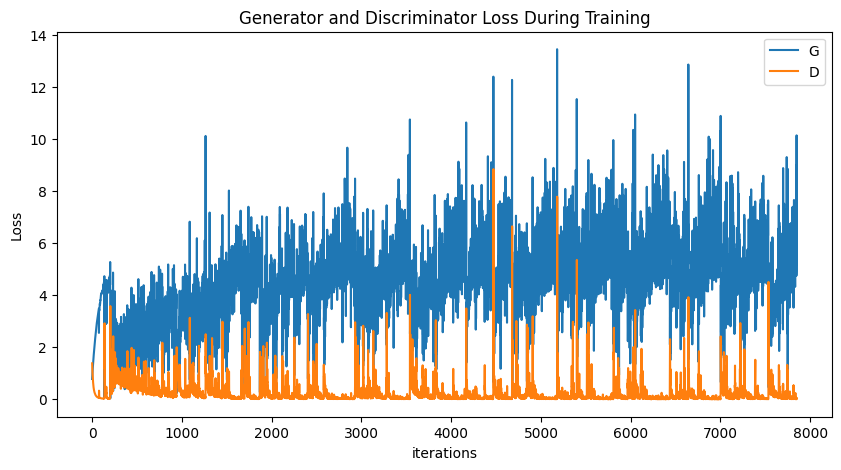

In [82]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [84]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(DCGAN.dataloader))

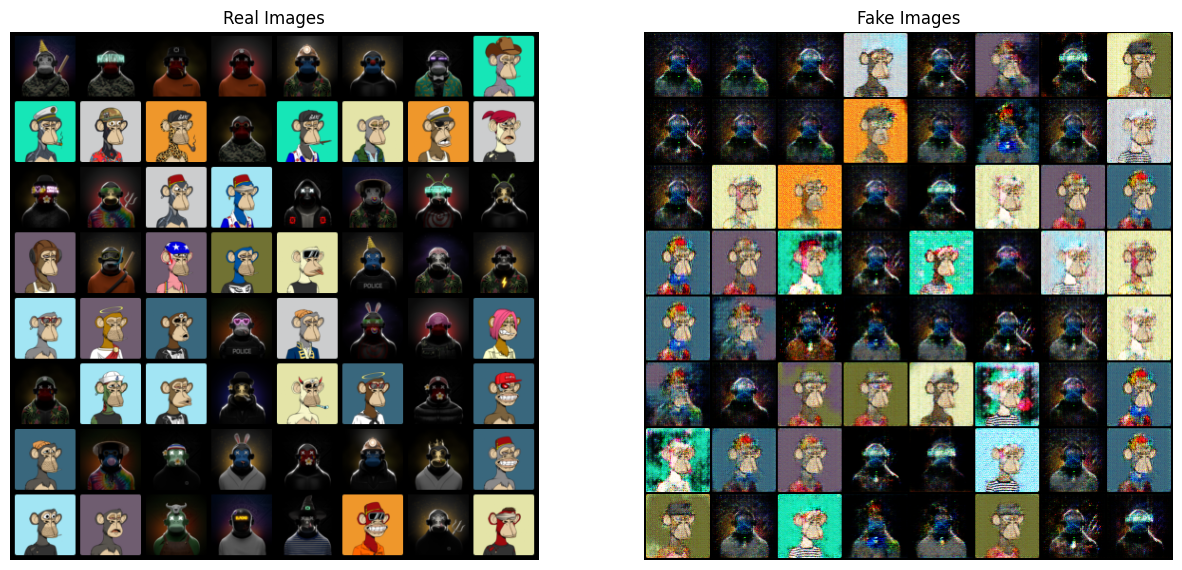

In [85]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DCGAN.device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

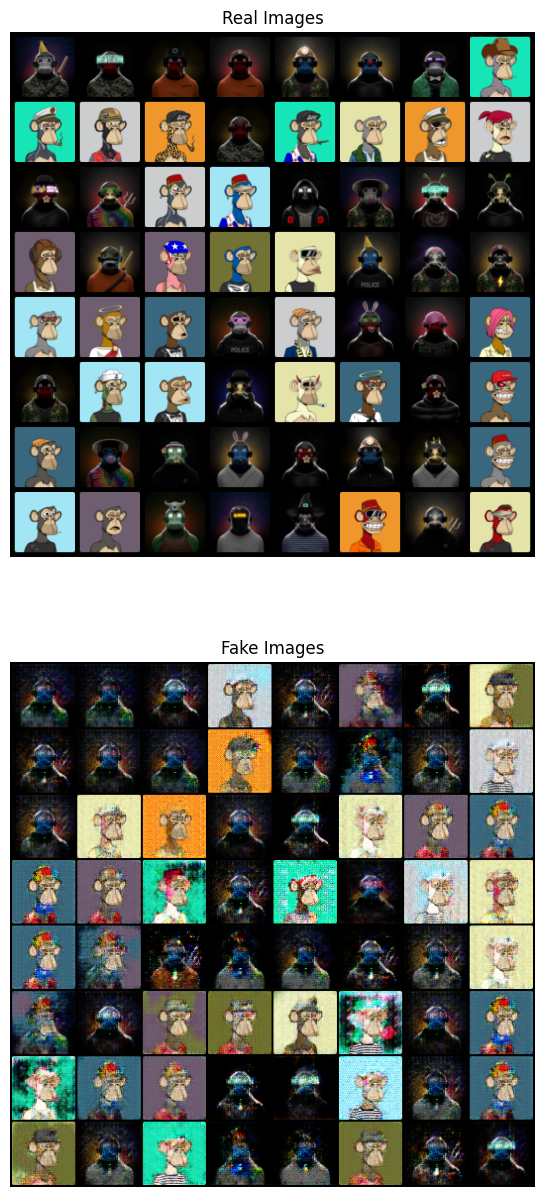

In [86]:
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DCGAN.device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(2,1,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()